<a href="https://colab.research.google.com/github/AashiDutt/AI-and-ML-for-Coders/blob/main/Chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab contains code for:

1. Techniques for predicting Time Series

  a) Naive Prediction to create a baseline

In [2]:
# Navive Prediction to create a baseline - bsic method to predict a time series
# is to say that predicted value at t+1 is same as the value at t, effectively shifting time series by single period.

#Creating Time Series

import matplotlib.pyplot as plt
import numpy as np

def trend(time, slope = 0):
  return slope * time

#Seasonality - data repeats itself after a time
def seasonal_pattern(season_time): 
  return np.where(season_time < 0.4, np.cos(season_time *2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude, phase = 0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# Noise is random perturbations in time series that increases unpredictability
def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange( 4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, .05)
baseline = 10
amplitude = 15
slope = 0.09
noise_level = 6


#create series

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#Update noise

series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end],series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

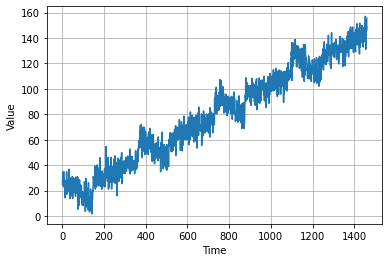

In [4]:
plot_series(time, series)

In [7]:
import tensorflow as tf

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


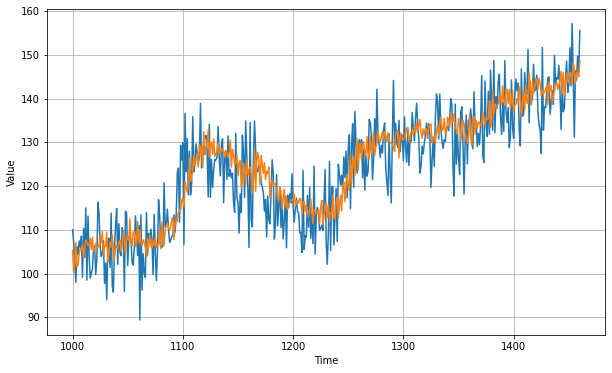

In [10]:
# Moving average for prediction
# instead of taking t-1 value to predict value at t
# take 30 values, average them to predict value at t

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
  

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.4588976

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(1e-08, 0.001, 0.0, 300.0)

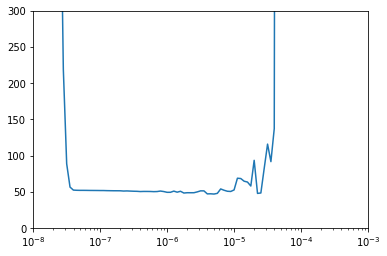

In [13]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [14]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


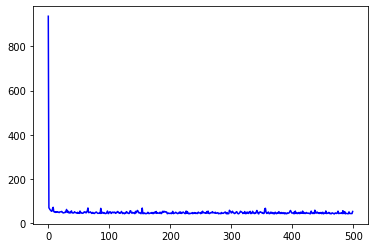

In [15]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[49.82967758178711, 51.01162338256836, 48.26856231689453, 51.535308837890625, 48.622581481933594, 51.448211669921875, 50.34285354614258, 48.304744720458984, 47.588871002197266, 50.61688232421875, 50.71441650390625, 51.20555114746094, 52.68561935424805, 49.343658447265625, 46.42033386230469, 46.08127975463867, 46.98208999633789, 48.660430908203125, 48.03781509399414, 54.425479888916016, 61.77878952026367, 48.214256286621094, 54.51589584350586, 48.08919143676758, 45.79549026489258, 49.98202133178711, 45.72346496582031, 51.42666244506836, 55.1293830871582, 46.02045822143555, 46.26755142211914, 45.56859588623047, 46.18327713012695, 51.490455627441406, 48.470115661621094, 46.906761169433594, 46.69224548339844, 44.3992919921875, 48.774078369140625, 45.28192901611328, 47.562252044677734, 44.177093505859375, 54.54331970214844, 46.11656951904297, 47.83707809448242, 45.33274841308594, 44.43809127807617, 44.63925552368164, 48.36841583251953, 50.621002197265625, 47.805049896240234, 49.856315612792

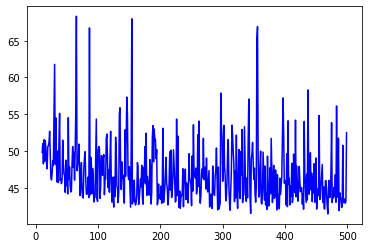

In [16]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

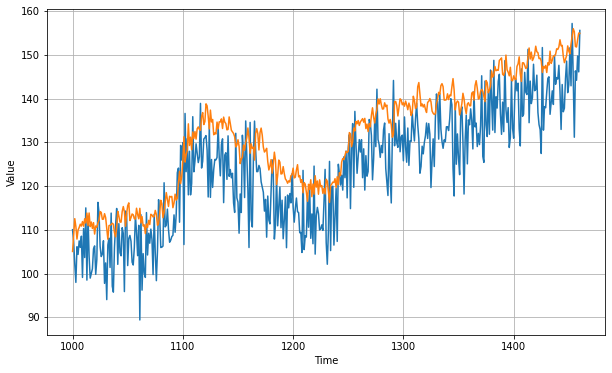

In [17]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.269425